## Group 42 Project - Prize Predictions

### Introduction

The Association of Tennis Professionals (ATP) tennis circuit is for the best male tennis players in the world. The players are ranked based on how many points they accumulate when competing in ATP level tournaments. The better they perform in each tournament (i.e. the more rounds they win), the more points they accumulate, and the higher the players are ranked. Additionally, for each round that a player wins, they win a certain amount of prize money. As such, the player who wins the tournament receives the most amount of points and prize money, which can vary based on the tournament. Points are updated on a weekly basis, and they are disregarded after 1 year. 

In this project we are trying to predict what a player’s prize money would be based on factors including their current ranking, points accumulated, and their best rank. 

To do so, we are using the dataset: player_stats. The dataset contains information such as the best ranking and handedness of the current top 500 tennis players in the ATP. Some columns and rows are very sparse, as much information is missing. Currently, the players are not ranked in order. 


### Data Analysis 

In [8]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)

In [6]:
#Demonstrate that the dataset can be read from the web into R
tennis_data <- read_csv("player_stats.csv")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [45]:
#Clean and wrangle your data into a tidy format
names(tennis_data)[names(tennis_data) == 'Prize Money'] <- 'prize_money'#renames Prize Money column to prize_money
tidy_tennis <- tennis_data |>
    select(Age:Plays,("Current Rank"):prize_money)|> #Removes columns with high proportions of NA 
    separate(col=Age,into=c("age","birth_date"),sep=" ")|> #Separates age and birth date into seperate columns
    separate(col=("Current Rank"),into=c("current_rank","points"),sep=" ")|> #Separates current rank and points into separate columns)
    separate(col=("Best Rank"),into=c("best_rank", "best_rank_date"),sep=" ")|> #Separates best rank and date of best rank into separate columns
    mutate(birth_date= gsub("[()]","",birth_date)) |> #Removes brackets
    mutate(points= gsub("[()]", "", points)) |> #Removes brackets
    mutate(best_rank_date=gsub("[()]","",best_rank_date))|> #Removes brackets
    mutate(birth_date=as_date(birth_date, format='%d-%m-%Y')) |> #Converts birth_date column to date objects
    mutate(best_rank_date=as_date(best_rank_date, format='%d-%m-%Y')) |> #Converts best_rank_date column to date objects
    mutate(age=as.numeric(age)) |> #Converts age column to numberic objects
    mutate(current_rank=as.numeric(current_rank)) |> #Converts current_rank column to numberic objects
    mutate(points=as.numeric(points)) |> #Converts points column to numberic objects
    mutate(best_rank=as.numeric(best_rank))|> #Converts best_rank column to numberic objects
    mutate(prize_money=gsub("[US$,]","",prize_money))|> #Removes some of the non-numeric aspects of prize_money data
    separate(col=prize_money,into=c("prize_money","x"),sep=". ") |> #removes the remaining non-numeric aspects of prize_money data
    select(age:prize_money) |> #removes unnecessary x column, which contained removed non-numeric aspects of prize-money data
    mutate(prize_money=as.numeric(prize_money))
head(tidy_tennis)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [16, 96, 128, 142,
208, 212, 267, 274, 337, 363, 364, 381, 394, 414, 423, 435, 436, 461, 468,
497].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 397 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”


age,birth_date,Country,Plays,current_rank,points,best_rank,best_rank_date,Name,Backhand,prize_money
<dbl>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<chr>,<chr>,<dbl>
26,1993-04-25,Brazil,Right-handed,378,97,363,2019-11-04,Oscar Jose Gutierrez,NA,NA
18,2001-12-22,United Kingdom,Left-handed,326,119,316,2019-10-14,Jack Draper,Two-handed,59040
32,1987-11-03,Slovakia,Right-handed,178,280,44,2013-01-14,Lukas Lacko,Two-handed,3261567
21,1998-05-29,"Korea, Republic of",Right-handed,236,199,130,2017-04-10,Duck Hee Lee,Two-handed,374093
27,1992-10-21,Australia,Right-handed,183,273,17,2016-01-11,Bernard Tomic,Two-handed,6091971
22,1997-02-11,Poland,Right-handed,31,1398,31,2020-01-20,Hubert Hurkacz,Two-handed,1517157


In [ ]:
#Using only training data, summarize the data in at least one table (this is exploratory data analysis).
tidy_tennis <- tidy_tennis |>
    select(age,birth_date, Country, current_rank, points, best_rank, best_rank_date, prize_money)
tennis_split <- initial_split(tidy_tennis, prop = 0.75, strata = prize_money)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)
tennis_list <- list(Column=c("age","birth_date","Country","current_rate","points","best_rank","best_rank_date","prize_money"),Approximate_Mean=c(26,"NA","NA",247,447,173,"NA",2111817),Mode=c(25,"NA","France","NA",73,78,"NA","NA"),Rows_with_Missing_Data=c(1,0,1,5,5,1,0,65))
tennis_summary <- data.frame(tennis_list)
tennis_summary

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


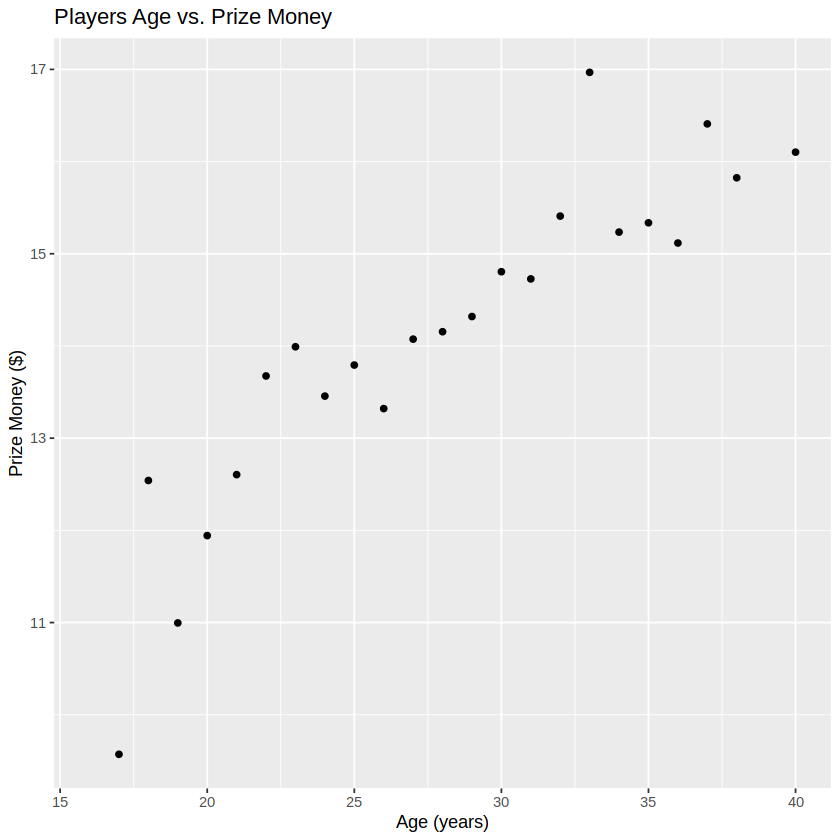

In [44]:
tennis_plot <- tennis_training |>
    group_by(age) |>
    summarise(prize_money = mean(prize_money, na.rm=TRUE)) |>
    ggplot(aes(x = age, y = log(prize_money))) + 
    geom_point() + 
    labs(x = "Age (years)", y = "Prize Money ($)") + 
    ggtitle("Players Age vs. Prize Money")

tennis_plot

### Method

Using the dataset, we will be performing a regression analysis. This form of analysis was chosen because we are trying to predict a numerical value. We will be using the columns: age, birth_date, current_rank, points, best_rank, best_rank_date, and prize_money, as we expect them to influence the amount of prize money a player accrues. All other columns will be disregarded when performing regression as they do not aid our predictions, or are missing a significant portion of their values. Using regression analysis, we will create a hypothetical ATP tennis player and predict how much prize money they will earn based on their current statistics. 

To visualize the results, we will be creating multiple scatter plots each of which would visualize how a certain variable (age, birth_date, current_rank, points, best_rank, best_rank_date, or prize_money) affects prize money amount (in dollars, most likely scaled to accommodate for the large range). To these plots we will add a second layer indicating our model's predicted values given the relevant variable. In doing so, we will be able to see trends in the predicting variable, as well as the precision of our model in anticipating the effect of that variable on prize money.


### Expected Outcomes and Significance

By performing regression analysis, we are expecting to find that certain factors contribute significantly to the amount of prize money a player earns. We are hypothesizing that factors age and current rank will impact prize money the most. Specifically, the lower the age and the higher the rank, the more prize money the player is expected to receive. 

The implications of these findings is that they could allow players to assess their expected financial trajectory, and decide whether continuing as a tennis professional is a worthy investment. Additionally, these findings are useful for investors as they are able to analyze which player has the most financial potential. Overall, this data allows multiple parties to see how they could maximize their income. 

Through this analysis, there are many future questions that can be proposed. For example, we could use these statistics to analyze how much money an ATP tennis player is expected to make from endorsements, or to predict at what age a tennis player will retire.